In [1]:
## Emma's version of the code for the 728 Project

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import zeta, roots_laguerre
from scipy.integrate import solve_ivp, quad

In [6]:
class Abundance():
    def __init__(self, T0=1e1, T1=1e-2, N_nu=3):
        #Constants
        self.node = roots_laguerre(64)[0]
        self.weight = roots_laguerre(64)[1]
        self.Q_np = 1.29    # {MeV}, difference between neutron and proton masses
        self.elem = {0: "n", 1: "p", 2: "2H", 3: "3H", 4: "3He", 5: "4He", 6: "7Li", 7: "7Be"}
        self.A = {"n": 1, "p": 1, "2H": 2, "3H": 3, "3He": 3, "4He": 4, "7Li": 7, "7Be": 7}
        self.B = {"n": 0, "p": 0, "2H": 2.22, "3H": 8.48, "3He": 7.72, "4He": 28.3, "7Li": 39.25, "7Be": 37.6}
        self.gA = {"n": 2, "p": 2, "2H": 3, "3H": 2, "3He": 2, "4He": 1, "7Li": 4, "7Be": 4}
        self.h = 1.15e-5
        self.H0 = 1
        self.me = 0.510998911
        self.G = 6.70881e-45
        self.hbar = 6.58211899e-22
        self.k_B = 8.617343e-11 #MeV/K
        self.eta = 5e-10
        self.T0, self.T1 = T0, T1   # {MeV}, initial, final Temperatures
        self.N_nu = N_nu
        self.tau_n = 885.7      # {s}, decay time for neutron
        self.zeta3 = 1.2020569031595942854
        self.c = 2.99792458e10              # {cm/s}, speed of light
        self.nhc3 = 2.75*self.eta*2*self.zeta3/(np.pi**2 * (self.hbar * self.c)**3)
        self.q = self.Q_np/self.me #added 
        self.k = 1/quad(lambda x: np.sqrt(x**2-1)*x*(self.q-x)**2, 1, self.q)[0]


        self.T, self.T_nu, self.time = self.expansion(10*T0, T1) #took away an N_nu

        p_to_n, n_to_p = self.weak_rate(self.T, self.T_nu, self.tau_n)
        self.interp = interp1d(self.time, [self.T,self.T_nu, p_to_n, n_to_p], 'cubic', fill_value='extrapolate') # added in the vstack to get arrays the same shape

        #Lists and Stuff 
        self.int_rates_a = np.array([
            [2.5e4, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [2.23e3, 0, 1, 0.112, 3.38, 2.65, 0, 0, 0, -3.72],
            [1, 0, 0, 0, 75.5, 0, 0, 1250, 0, 0],
            [7.06e8, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [2.87e4, 0, 1, 0.108, 0.466, 0.352, 0.3, 0.576, 0, -3.87],
            [6e3, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [3.9e8, 0, 1, 0.0979, 0.642, 0.44, 0, 0, 0, -4.26],
            [3.9e8, 0, 1, 0.0979, 0.642, 0.44, 0, 0, 0, -4.26],
            [24.1, 0, 0, 0, 1, .685, .152, .265, 0, -4.26],
            [2.6e9, 1, 0, 0, 0, 0, 0, 0, -2.99, 0],
            [1.38e9, 1, 0, 0, 0, 0, 0, 0, -0.745, 0],
            [1.19e10, 0, 1, 0.034, 0, 0, 0, 0, 0, -12.25],
            [1.10e9, 0, 1, 0.0857, 0, 0, 0, 0, 0, -4.87],
            [5.60e9, 0, 1, 0.054, 0, 0, 0, 0, 0, -7.72],
            [3.88e9, 0, 1, 0.054, 0, 0, 0, 0, 0, -7.72],
            [4.8e6, 0, 1, 0.0326, -.219, -.0499, .0258, .015, 0, -12.8],
            [5.28e5, 0, 1, 0.0516, 0, 0, 0, 0, 0, -8.08],
            [6.74e9, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [1.42e9, 0, 1, 0.0493, 0, 0, 0, 0, 0, -8.47],
            [1.2e7, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
        ])
        self.int_rates_b = np.array([ 
            [4.68e9, -1, 3/2, -25.82],
            [1.63e10, -1, 3/2, -63.75], 
            [1.63e10, -1, 3/2, -72.62], 
            [1, 0, 0, -8.864], 
            [2.59e10, -1, 3/2, -229.9], 
            [2.6e10, -1, 3/2, -238.8], 
            [1.73, 0, 0, -37.94], 
            [1.73, 0, 0, -46.8], 
            [4.5e10, -1, 3/2, -276.7], 
            [5.5, 0, 0, -213], 
            [5.5, 0, 0, -204.1], 
            [3.37e-10, 1, -3/2, -149.2], 
            [3.37e-10, 1, -3/2, -131.5], 
            [3.37e-10, 1, -3/2, -140.4], 
            [1.59, 0, 0, -166.2], 
            [1.12e10, -1, 3/2, -18.42], 
            [1.12e10, -1, 3/2, -28.63], 
            [1, 0, 0, -19.07], 
            [4.64, 0, 0, -201.3], 
            [4.64, 0, 0, -220.4]
        ])
    
    def expansion(self,T0,T1,nstep=256):
        T = np.geomspace(T0,T1,nstep)
        soln_t = solve_ivp(self.dt_dT,T[[0,-1]],[0],t_eval=T)
        soln_Tnu = solve_ivp(self.dTnu_dT,T[[0,-1]],[T0],t_eval=T)
        return soln_t.t, soln_Tnu.y[0], soln_t.y[0]
    
    def weak_rate(self, T, T_nu, tau_n):
        mT = self.me/T
        a = np.expand_dims(mT, -1)
        b = np.expand_dims(T/T_nu, -1)
        c = np.expand_dims(self.q*mT, -1)

        x = self.node
        y = x+a
        z = np.exp(y)
        z1,z2 = np.exp((y+c)*b), np.exp((y-c)*b)
        y1,y2 = (y+c)**2/(z1+1), (y-c)**2/(z2+1)
        f = np.asarray([y1*z + y2*z2, y2*z + y1*z1])
        f *= y*np.sqrt(x*(x+2*a))/(z+1)*np.exp(x)
        f = np.dot(f, self.weight)# integral [0,infty]

        return f/mT**5*self.k/tau_n

    def electron_gas(self, T): 
        """
            Calculates rho_e, P_e, and c_e for any given temperature.
        """
        a = np.expand_dims(self.me/T, -1)
        x = self.node
        x2 = x*x
        y = np.sqrt(x*x + a*a)
        z = np.exp(y)
        f = np.asarray([y, x2/y/3, y*y*z/(z+1)])
        f*= x2/(z+1)*np.exp(x)
        f = np.dot(f, self.weight)
        f*= T**4*2/np.pi**2 
        return f
    
    def rho(self, T):
        """
            Calculates rho for any given temperature.
        """
        N_nu = 3
        rho_r = np.pi**2/15*T**4
        rho_nu = 7/8*np.pi**2/15*N_nu*T**4
        rho_e = self.electron_gas(T)[0]
        rho_total = rho_e + rho_nu + rho_r
        return rho_total
    
    def dr_dT(self,T, r):
        """
            Calculates dr/dT for any given temperature.
        """
        rho_r = np.pi**2/15*T**4
        P_e = self.electron_gas(T)[1] 
        P_r = rho_r/15*T**4/3
        P = P_e + P_r 
        c_e = self.electron_gas(T)[2]
        c_r = rho_r*4
        c = (c_e + c_r)/T
        return -c/(P + self.rho(T))
    
    def H(self, T):
        """
            Calculates the value of Hubble at any given time.
        """
        return np.sqrt(8*np.pi*self.G/3)*np.sqrt(self.rho(T))/self.hbar
    
    def dTnu_dT(self,T,T_nu):
        T_nu = self.T0
        dr_dT = self.dr_dT(T,r=0)
        return T_nu * dr_dT

    def dt_dT(self, T, r): #changed, r used to be a t
        """
            Calculates dt/dT for any given temperature.
        """ 
        return self.dr_dT(T,r=0)/(3*self.H(T)) #changed, used to be just self.H
    
    def X_eq(self, elemKey, T):
        """
            Calculates dr/dT for any given temperature.
        """
        A = self.A[elemKey]
        zeta = zeta(3)
        g = self.gA[elemKey]
        prefactor = g * zeta**(A-1) * 2**((3*A-5)/2) * np.pi**((1-A)/2) * A**(5/2)
        return 
    
    def rho_b(self, T):
        """
            Calculates the baryon density.

            Parameters:
                T: (float), temperature
            Returns:
                rho_b: (float), baryon density
        """
        return self.h * T**3
    
    def interaction_rates_a(self, reactionIdx, T):
        """
            Gives the interaction rate equation for reaction.

            Parameters:
                reactionIdx: (int), index for reaction equation
            Returns:
                int_rate: (float), interaction rate for given T, rho_b 
        """
        rho_b = self.rho_b(T)
        a = self.int_rates_a[reactionIdx][0]
        b = self.int_rates_a[reactionIdx][1:8]
        c = self.int_rates_a[reactionIdx][8:]
        T9 = T/(self.k_B*1e9)
        polynomial = b[0]*T9**(-3/2) + sum([b[i+1]*T9**((i-2)/3) for i in range(len(b)-1)])
        exponential = np.exp(c[0]*T9**(-1) + c [1]*(T9**(-1/3)))
        return a * rho_b * polynomial * exponential
    
    def interaction_rates_b(self, reactionIdx, T):
        """
            Gives the f_i equation for reaction. 
            
            Parameters: 
                fIdx: (int), index for the f_i equations
            Returns: 
                f_i: (float), f_F for the given T, rho_b
        """ 
        rho_b = self.rho_b(T)
        a,b,c,d = self.int_rates_b[reactionIdx]
        T9 = T/(self.k_B*1e9)
        return a * rho_b**(b) * T9**c * np.exp(d*T9**(-1)) * self.interaction_rates_a(reactionIdx, T)
    
    def dXA_dt(self, T, X_A):
        """
            Calculate the derivatives from the rate equations.

        """
        dX0_dt = self.X_A[2]*self.interaction_rates_b(0,T) + self.X_A[4]*self.interaction_rates_b(1,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[5]*self.interaction_rates_b(4,T) + .5*self.X_A[2]*self.interaction_rates_a(7,T) + self.X_A[2]*self.X_A[4]*self.interaction_rates_a(9,T) + .5*self.X_A[4]**2*self.interaction_rates_a(11,T) + self.X_A[4]*self.X_A[3]*self.interaction_rates_a(13,T) + self.X_A[1]*self.X_A[6]*self.interaction_rates_a(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(18,T) - self.X_A[0]*(self.X_A[1]*self.interaction_rates_a(0,T) + self.X_A[2]*self.interaction_rates_a(1,T) + self.X_A[3]*self.interaction_rates_b(3,T) + self.X_A[3]*self.interaction_rates_a(4,T) + self.X_A[3]*self.interaction_rates_b(7,T) + self.X_A[5]*self.interaction_rates_b(9,T) + .5*self.X_A[5]*self.X_A[0]*self.interaction_rates_b(11,T) + self.X_A[5]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[6]*self.interaction_rates_b(17,T) + self.X_A[6]*self.interaction_rates_a(18,T))
        dX1_dt = self.X_A[2]*self.interaction_rates_b(0,T) + self.X_A[3]*self.interaction_rates_b(2,T) + self.X_A[3]*self.X_A[0]*self.interaction_rates_b(3,T) + self.X_A[5]*self.interaction_rates_b(5,T) +.5*self.X_A[2]**2*self.interaction_rates_a(6,T) + self.X_A[2]*self.X_A[3]*self.interaction_rates_a(10,T) + self.X_A[3]**2*self.interaction_rates_a(12,T) + self.X_A[3]*self.X_A[4]*self.interaction_rates_a(13,T) + self.X_A[6]*self.X_A[0]*self.interaction_rates_b(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(19,T) - self.X_A[1]*(self.X_A[0]*self.interaction_rates_a(0,T) + self.X_A[2]*self.interaction_rates_a(2,T) + self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[4]*self.interaction_rates_a(5,T) + self.X_A[4]*self.interaction_rates_b(6,T) + self.X_A[5]*self.interaction_rates_b(10,T) + self.X_A[1]*self.X_A[5]*self.interaction_rates_b(12,T) + self.X_A[0]*self.X_A[5]*self.interaction_rates_b(13,T) + self.X_A[7]*self.interaction_rates_a(17,T) + self.X_A[7]*self.interaction_rates_a(19,T))
        dX2_dt = self.X_A[0]*self.X_A[1]*self.interaction_rates_a(0,T) + self.X_A[4]*self.interaction_rates_b(1,T) + self.X_A[3]*self.interaction_rates_b(2,T) + 2*self.X_A[4]*self.interaction_rates_b(6,T) + 2*self.X_A[3]*self.interaction_rates_b(7,T) + self.X_A[5]*(2*self.interaction_rates_b(8,T) +self.interaction_rates_b(9,T) + self.interaction_rates_b(10,T)) + self.X_A[4]*self.X_A[3]*self.interaction_rates_a(14,T) - self.X_A[2]*(self.interaction_rates_b(0,T) + self.X_A[0]*self.interaction_rates_a(1,T) + self.X_A[1]*self.interaction_rates_a(2,T) + self.X_A[2]*(self.interaction_rates_a(6,T) + self.interaction_rates_a(7,T) + self.interaction_rates_a(8,T)) + self.X_A[4]*self.interaction_rates_a(9,T) + self.X_A[3]*self.interaction_rates_a(10,T) + self.X_A[5]*self.interaction_rates_b(14,T)) 
        dX3_dt = self.X_A[1]*self.X_A[2]*self.interaction_rates_a(2,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[5]*self.interaction_rates_b(4,T) + .5*self.X_A[2]**2*self.interaction_rates_a(7,T) + self.X_A[5]*self.X_A[1]*(self.interaction_rates_b(10,T) + self.X_A[1]*self.interaction_rates_b(12,T) + self.X_A[0]*self.interaction_rates_b(13,T)) + self.X_A[5]*self.X_A[2]*self.interaction_rates_b(14,T) + self.X_A[6]*self.interaction_rates_b(16,T) - self.X_A[3]*(self.interaction_rates_b(2,T) + self.X_A[0]*(self.interaction_rates_b(3,T) + self.interaction_rates_a(4,T) + self.interaction_rates_b(7,T)) + self.X_A[2]*self.interaction_rates_a(10,T) + self.X_A[3]*self.interaction_rates_a(12,T) + self.X_A[4]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[5]*self.interaction_rates_a(16,T))
        dX4_dt = self.X_A[0]*self.X_A[2]*self.interaction_rates_a(1,T) + self.X_A[0]*self.X_A[3]*self.interaction_rates_b(3,T) + self.X_A[5]*self.interaction_rates_b(5,T) + .5*self.X_A[2]**2*self.interaction_rates_a(6,T) + self.X_A[5]*self.X_A[0]*self.interaction_rates_b(9,T) + self.X_A[5]*self.X_A[0]**2*self.interaction_rates_b(11,T) + self.X_A[5]*self.X_A[0]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[5]*self.X_A[2]*self.interaction_rates_b(14,T) * self.X_A[7]*self.interaction_rates_b(15,T) - self.X_A[4]*(self.interaction_rates_b(1,T) + self.X_A[1]*(self.interaction_rates_a(3,T) + self.interaction_rates_a(5,T) + self.interaction_rates_b(6,T)) + self.X_A[2]*self.interaction_rates_a(9,T) + self.X_A[4]*self.interaction_rates_a(11,T) + self.X_A[3]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[5]*self.interaction_rates_a(15,T))
        dX5_dt = self.X_A[0]*self.X_A[3]*self.interaction_rates_a(4,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(5,T) + .5*self.X_A[2]**2*self.interaction_rates_a(8,T) + self.X_A[2]*self.X_A[4]*self.interaction_rates_a(9,T) + self.X_A[2]*self.X_A[3]*self.interaction_rates_a(10,T) + .5*self.X_A[4]**2*self.interaction_rates_a(11,T) + .5*self.X_A[3]**2*self.interaction_rates_a(12,T) + self.X_A[4]*self.X_A[3]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[7]*self.interaction_rates_b(15,T) + self.X_A[6]*self.interaction_rates_b(16,T) + 2*self.X_A[0]*self.X_A[6]*self.interaction_rates_a(18,T) + 2*self.X_A[1]*self.X_A[7]*self.interaction_rates_a(19,T) - self.X_A[5]*(self.interaction_rates_b(4,T) + self.interaction_rates_b(5,T) + self.interaction_rates_b(8,T) + self.X_A[0]*self.interaction_rates_b(9,T) + self.X_A[1]*self.interaction_rates_b(10,T) + self.X_A[0]**2*self.interaction_rates_b(11,T) + self.X_A[1]**2*self.interaction_rates_b(12,T) + self.X_A[0]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[2]*self.interaction_rates_b(14,T) + self.X_A[4]*self.interaction_rates_a(15,T) + self.X_A[3]*self.interaction_rates_a(16,T) + self.X_A[5]*(self.interaction_rates_b(18,T) + self.interaction_rates_b(19,T)))
        dX6_dt = self.X_A[3]*self.X_A[5]*self.interaction_rates_a(16,T) + self.X_A[1]*self.X_A[7]*self.interaction_rates_a(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(18,T) - self.X_A[6]*(self.interaction_rates_b(16,T) + self.X_A[0]*self.interaction_rates_b(17,T) + self.X_A[0]*self.interaction_rates_a(18,T))
        dX7_dt = self.X_A[4]*self.X_A[5]*self.interaction_rates_a(15,T) + self.X_A[0]*self.X_A[6]*self.interaction_rates_b(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(19,T) - self.X_A[7]*(self.interaction_rates_b(15,T) + self.X_A[1]*(self.interaction_rates_a(17,T) + self.interaction_rates_a(18,T))) 

        return np.array([dX0_dt, dX1_dt, dX2_dt, dX3_dt, dX4_dt, dX5_dt, dX6_dt, dX7_dt])

    def BBN(self, nsteps=256):
        t0, t1 = np.interp([self.T0, self.T1], self.T[::-1], self.time[::-1])
        # t_span = (t0 * .999999, t1)
        # t = np.round(np.geomspace(t0, t1, nsteps), decimals=10)
        t = np.geomspace(t0*1.000001, t1, nsteps)
        # t = np.clip(t, t_span[0], t_span[1] - 1e-5)
        self.X_A = np.zeros(len(self.elem))  # Match size to number of elements

        # Set the neutron and proton initial conditions
        self.X_A[0] = 1 / (np.exp(self.Q_np / self.T0) + 1)
        self.X_A[1] = 1 - self.X_A[0]

        # Solve ODEs
        soln = solve_ivp(self.dXA_dt, [t0, t1], self.X_A, method='LSODA', t_eval=t)

        # Convert results using atomic masses
        A_values = np.array([self.A[key] for key in self.elem.values()])
        X = (soln.y.T * A_values).T
        return np.interp(t, self.time, self.T), X

In [3]:
4.115605294926381e-05 - 4.11561e-05
3332.0823551589738 -  3332.082355159

-2.637534635141492e-11

In [4]:
# class Abundance():
#     def __init__(self, T0=1e1, T1=1e-2, N_nu=3):
#         #Constants
#         self.node = roots_laguerre(64)[0]
#         self.weight = roots_laguerre(64)[1]
#         self.Q_np = 1.29    # {MeV}, difference between neutron and proton masses
#         self.elem = {0: "n", 1: "p", 2: "2H", 3: "3H", 4: "3He", 5: "4He", 6: "7Li", 7: "7Be"}
#         self.A = {"n": 1, "p": 1, "2H": 2, "3H": 3, "3He": 3, "4He": 4, "7Li": 7, "7Be": 7}
#         self.B = {"n": 0, "p": 0, "2H": 2.22, "3H": 8.48, "3He": 7.72, "4He": 28.3, "7Li": 39.25, "7Be": 37.6}
#         self.gA = {"n": 2, "p": 2, "2H": 3, "3H": 2, "3He": 2, "4He": 1, "7Li": 4, "7Be": 4}
#         self.h = 1.15e-5
#         self.H0 = 1
#         self.me = 0.510998911
#         self.G = 6.70881e-45
#         self.hbar = 6.58211899e-22
#         self.k_B = 8.617343e-11 #MeV/K
#         self.eta = 5e-10
#         self.T0, self.T1 = T0, T1   # {MeV}, initial, final Temperatures
#         self.N_nu = N_nu
#         self.tau_n = 885.7      # {s}, decay time for neutron
#         self.zeta3 = 1.2020569031595942854
#         self.c = 2.99792458e10              # {cm/s}, speed of light
#         self.nhc3 = 2.75*self.eta*2*self.zeta3/(np.pi**2 * (self.hbar * self.c)**3)
#         self.q = self.Q_np/self.me #added 
#         self.k = 1/quad(lambda x: np.sqrt(x**2-1)*x*(self.q-x)**2, 1, self.q)[0]


#         self.T, self.T_nu, self.time = self.expansion(10*T0, T1) #took away an N_nu
#         print(len(self.time), len(self.T), len(self.T_nu))

#         p_to_n, n_to_p = self.weak_rate(self.T, self.T_nu, self.tau_n)
#         print(len(self.time), len(self.T), len(self.T_nu), len(p_to_n), len(n_to_p))
#         self.interp = interp1d(self.time, [self.T,self.T_nu, p_to_n, n_to_p], 'cubic', fill_value='extrapolate') # added in the vstack to get arrays the same shape

#         #Lists and Stuff 
#         self.int_rates_a = np.array([
#             [2.5e4, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [2.23e3, 0, 1, 0.112, 3.38, 2.65, 0, 0, 0, -3.72],
#             [1, 0, 0, 0, 75.5, 0, 0, 1250, 0, 0],
#             [7.06e8, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [2.87e4, 0, 1, 0.108, 0.466, 0.352, 0.3, 0.576, 0, -3.87],
#             [6e3, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [3.9e8, 0, 1, 0.0979, 0.642, 0.44, 0, 0, 0, -4.26],
#             [3.9e8, 0, 1, 0.0979, 0.642, 0.44, 0, 0, 0, -4.26],
#             [24.1, 0, 0, 0, 1, .685, .152, .265, 0, -4.26],
#             [2.6e9, 1, 0, 0, 0, 0, 0, 0, -2.99, 0],
#             [1.38e9, 1, 0, 0, 0, 0, 0, 0, -0.745, 0],
#             [1.19e10, 0, 1, 0.034, 0, 0, 0, 0, 0, -12.25],
#             [1.10e9, 0, 1, 0.0857, 0, 0, 0, 0, 0, -4.87],
#             [5.60e9, 0, 1, 0.054, 0, 0, 0, 0, 0, -7.72],
#             [3.88e9, 0, 1, 0.054, 0, 0, 0, 0, 0, -7.72],
#             [4.8e6, 0, 1, 0.0326, -.219, -.0499, .0258, .015, 0, -12.8],
#             [5.28e5, 0, 1, 0.0516, 0, 0, 0, 0, 0, -8.08],
#             [6.74e9, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [1.42e9, 0, 1, 0.0493, 0, 0, 0, 0, 0, -8.47],
#             [1.2e7, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
#         ])
#         self.int_rates_b = np.array([ 
#             [4.68e9, -1, 3/2, -25.82],
#             [1.63e10, -1, 3/2, -63.75], 
#             [1.63e10, -1, 3/2, -72.62],
#             [1, 0, 0, -8.864], 
#             [2.59e10, -1, 3/2, -229.9], 
#             [2.6e10, -1, 3/2, -238.8], 
#             [1.73, 0, 0, -37.94], 
#             [1.73, 0, 0, -46.8], 
#             [4.5e10, -1, 3/2, -276.7], 
#             [5.5, 0, 0, -213], 
#             [5.5, 0, 0, -204.1], 
#             [3.37e-10, 1, -3/2, -149.2], 
#             [3.37e-10, 1, -3/2, -131.5], 
#             [3.37e-10, 1, -3/2, -140.4], 
#             [1.59, 0, 0, -166.2], 
#             [1.12e10, -1, 3/2, -18.42], 
#             [1.12e10, -1, 3/2, -28.63], 
#             [1, 0, 0, -19.07], 
#             [4.64, 0, 0, -201.3], 
#             [4.64, 0, 0, -220.4]
#         ])
    
#     def expansion(self,T0,T1,nstep=256):
#         T = np.geomspace(T0,T1,nstep)
#         soln_t = solve_ivp(self.dt_dT,T[[0,-1]],[0],t_eval=T)
#         soln_Tnu = solve_ivp(self.dTnu_dT,T[[0,-1]],[T0],t_eval=T)
#         print(len(soln_t.t), len(soln_Tnu.y[0]), len(soln_t.y[0]))
#         return soln_t.t, soln_Tnu.y[0], soln_t.y[0]
    
#     def weak_rate(self, T, T_nu, tau_n):
#         mT = self.me/T
#         a = np.expand_dims(mT, -1)
#         b = np.expand_dims(T/T_nu, -1)
#         c = np.expand_dims(self.q*mT, -1)

#         x = self.node
#         y = x+a
#         z = np.exp(y)
#         z1,z2 = np.exp((y+c)*b), np.exp((y-c)*b)
#         y1,y2 = (y+c)**2/(z1+1), (y-c)**2/(z2+1)
#         f = np.asarray([y1*z + y2*z2, y2*z + y1*z1])
#         f *= y*np.sqrt(x*(x+2*a))/(z+1)*np.exp(x)
#         f = np.dot(f, self.weight)# integral [0,infty]

#         return f/mT**5*self.k/tau_n

#     def electron_gas(self, T): 
#         """
#             Calculates rho_e, P_e, and c_e for any given temperature.
#         """
#         a = np.expand_dims(self.me/T, -1)
#         x = self.node
#         x2 = x*x
#         y = np.sqrt(x*x + a*a)
#         z = np.exp(y)
#         f = np.asarray([y, x2/y/3, y*y*z/(z+1)])
#         f*= x2/(z+1)*np.exp(x)
#         f = np.dot(f, self.weight)
#         f*= T**4*2/np.pi**2 
#         return f
    
#     def rho(self, T):
#         """
#             Calculates rho for any given temperature.
#         """
#         N_nu = 3
#         rho_r = np.pi**2/15*T**4
#         rho_nu = 7/8*np.pi**2/15*N_nu*T**4
#         rho_e = self.electron_gas(T)[0]
#         rho_total = rho_e + rho_nu + rho_r
#         return rho_total
    
#     def dr_dT(self,T, r):
#         """
#             Calculates dr/dT for any given temperature.
#         """
#         rho_r = np.pi**2/15*T**4
#         P_e = self.electron_gas(T)[1] 
#         P_r = rho_r/15*T**4/3
#         P = P_e + P_r 
#         c_e = self.electron_gas(T)[2]
#         c_r = rho_r*4
#         c = (c_e + c_r)/T
#         return -c/(P + self.rho(T))
    
#     def H(self, T):
#         """
#             Calculates the value of Hubble at any given time.
#         """
#         return np.sqrt(8*np.pi*self.G/3)*np.sqrt(self.rho(T))/self.hbar
    
#     def dTnu_dT(self,T,T_nu):
#         T_nu = self.T0
#         dr_dT = self.dr_dT(T,r=0)
#         return T_nu * dr_dT

#     def dt_dT(self, T, r): #changed, r used to be a t
#         """
#             Calculates dt/dT for any given temperature.
#         """ 
#         return self.dr_dT(T,r=0)/(3*self.H(T)) #changed, used to be just self.H
    
#     def X_eq(self, elemKey, T):
#         """
#             Calculates dr/dT for any given temperature.
#         """
#         A = self.A[elemKey]
#         zeta = zeta(3)
#         g = self.gA[elemKey]
#         prefactor = g * zeta**(A-1) * 2**((3*A-5)/2) * np.pi**((1-A)/2) * A**(5/2)
#         return 
    
#     def rho_b(self, T):
#         """
#             Calculates the baryon density.

#             Parameters:
#                 T: (float), temperature
#             Returns:
#                 rho_b: (float), baryon density
#         """
#         return self.h * T**3
    
#     def interaction_rates_a(self, reactionIdx, T):
#         """
#             Gives the interaction rate equation for reaction.

#             Parameters:
#                 reactionIdx: (int), index for reaction equation
#             Returns:
#                 int_rate: (float), interaction rate for given T, rho_b 
#         """
#         rho_b = self.rho_b(T)
#         # print(len(self.int_rates_a[19]))
#         a = self.int_rates_a[reactionIdx][0]
#         b = self.int_rates_a[reactionIdx][1:8]
#         c = self.int_rates_a[reactionIdx][8:]
#         T9 = T/(self.k_B*1e9)
#         polynomial = b[0]*T9**(-3/2) + sum([b[i+1]*T9**((i-2)/3) for i in range(len(b)-1)])
#         exponential = np.exp(c[0]*T9**(-1) + c [1]*(T9**(-1/3)))
#         return a * rho_b * polynomial * exponential
    
#     def interaction_rates_b(self, reactionIdx, T):
#         """
#             Gives the f_i equation for reaction. 
            
#             Parameters: 
#                 fIdx: (int), index for the f_i equations
#             Returns: 
#                 f_i: (float), f_F for the given T, rho_b
#         """ 
#         rho_b = self.rho_b(T)
#         a,b,c,d = self.int_rates_b[reactionIdx]
#         T9 = T/(self.k_B*1e9)
#         return a * rho_b**(b) * T9**c * np.exp(d*T9**(-1)) * self.interaction_rates_a(reactionIdx, T)
    
#     def dXA_dt(self, T, X_A):
#         """
#             Calculate the derivatives from the rate equations.

#         """
#         dX0_dt = self.X_A[2]*self.interaction_rates_b(0,T) + self.X_A[4]*self.interaction_rates_b(1,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[5]*self.interaction_rates_b(4,T) + .5*self.X_A[2]*self.interaction_rates_a(7,T) + self.X_A[2]*self.X_A[4]*self.interaction_rates_a(9,T) + .5*self.X_A[4]**2*self.interaction_rates_a(11,T) + self.X_A[4]*self.X_A[3]*self.interaction_rates_a(13,T) + self.X_A[1]*self.X_A[6]*self.interaction_rates_a(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(18,T) - self.X_A[0]*(self.X_A[1]*self.interaction_rates_a(0,T) + self.X_A[2]*self.interaction_rates_a(1,T) + self.X_A[3]*self.interaction_rates_b(3,T) + self.X_A[3]*self.interaction_rates_a(4,T) + self.X_A[3]*self.interaction_rates_b(7,T) + self.X_A[5]*self.interaction_rates_b(9,T) + .5*self.X_A[5]*self.X_A[0]*self.interaction_rates_b(11,T) + self.X_A[5]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[6]*self.interaction_rates_b(17,T) + self.X_A[6]*self.interaction_rates_a(18,T))
#         dX1_dt = self.X_A[2]*self.interaction_rates_b(0,T) + self.X_A[3]*self.interaction_rates_b(2,T) + self.X_A[3]*self.X_A[0]*self.interaction_rates_b(3,T) + self.X_A[5]*self.interaction_rates_b(5,T) +.5*self.X_A[2]**2*self.interaction_rates_a(6,T) + self.X_A[2]*self.X_A[3]*self.interaction_rates_a(10,T) + self.X_A[3]**2*self.interaction_rates_a(12,T) + self.X_A[3]*self.X_A[4]*self.interaction_rates_a(13,T) + self.X_A[6]*self.X_A[0]*self.interaction_rates_b(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(19,T) - self.X_A[1]*(self.X_A[0]*self.interaction_rates_a(0,T) + self.X_A[2]*self.interaction_rates_a(2,T) + self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[4]*self.interaction_rates_a(5,T) + self.X_A[4]*self.interaction_rates_b(6,T) + self.X_A[5]*self.interaction_rates_b(10,T) + self.X_A[1]*self.X_A[5]*self.interaction_rates_b(12,T) + self.X_A[0]*self.X_A[5]*self.interaction_rates_b(13,T) + self.X_A[7]*self.interaction_rates_a(17,T) + self.X_A[7]*self.interaction_rates_a(19,T))
#         dX2_dt = self.X_A[0]*self.X_A[1]*self.interaction_rates_a(0,T) + self.X_A[4]*self.interaction_rates_b(1,T) + self.X_A[3]*self.interaction_rates_b(2,T) + 2*self.X_A[4]*self.interaction_rates_b(6,T) + 2*self.X_A[3]*self.interaction_rates_b(7,T) + self.X_A[5]*(2*self.interaction_rates_b(8,T) +self.interaction_rates_b(9,T) + self.interaction_rates_b(10,T)) + self.X_A[4]*self.X_A[3]*self.interaction_rates_a(14,T) - self.X_A[2]*(self.interaction_rates_b(0,T) + self.X_A[0]*self.interaction_rates_a(1,T) + self.X_A[1]*self.interaction_rates_a(2,T) + self.X_A[2]*(self.interaction_rates_a(6,T) + self.interaction_rates_a(7,T) + self.interaction_rates_a(8,T)) + self.X_A[4]*self.interaction_rates_a(9,T) + self.X_A[3]*self.interaction_rates_a(10,T) + self.X_A[5]*self.interaction_rates_b(14,T)) 
#         dX3_dt = self.X_A[1]*self.X_A[2]*self.interaction_rates_a(2,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(3,T) + self.X_A[5]*self.interaction_rates_b(4,T) + .5*self.X_A[2]**2*self.interaction_rates_a(7,T) + self.X_A[5]*self.X_A[1]*(self.interaction_rates_b(10,T) + self.X_A[1]*self.interaction_rates_b(12,T) + self.X_A[0]*self.interaction_rates_b(13,T)) + self.X_A[5]*self.X_A[2]*self.interaction_rates_b(14,T) + self.X_A[6]*self.interaction_rates_b(16,T) - self.X_A[3]*(self.interaction_rates_b(2,T) + self.X_A[0]*(self.interaction_rates_b(3,T) + self.interaction_rates_a(4,T) + self.interaction_rates_b(7,T)) + self.X_A[2]*self.interaction_rates_a(10,T) + self.X_A[3]*self.interaction_rates_a(12,T) + self.X_A[4]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[5]*self.interaction_rates_a(16,T))
#         dX4_dt = self.X_A[0]*self.X_A[2]*self.interaction_rates_a(1,T) + self.X_A[0]*self.X_A[3]*self.interaction_rates_b(3,T) + self.X_A[5]*self.interaction_rates_b(5,T) + .5*self.X_A[2]**2*self.interaction_rates_a(6,T) + self.X_A[5]*self.X_A[0]*self.interaction_rates_b(9,T) + self.X_A[5]*self.X_A[0]**2*self.interaction_rates_b(11,T) + self.X_A[5]*self.X_A[0]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[5]*self.X_A[2]*self.interaction_rates_b(14,T) * self.X_A[7]*self.interaction_rates_b(15,T) - self.X_A[4]*(self.interaction_rates_b(1,T) + self.X_A[1]*(self.interaction_rates_a(3,T) + self.interaction_rates_a(5,T) + self.interaction_rates_b(6,T)) + self.X_A[2]*self.interaction_rates_a(9,T) + self.X_A[4]*self.interaction_rates_a(11,T) + self.X_A[3]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[5]*self.interaction_rates_a(15,T))
#         dX5_dt = self.X_A[0]*self.X_A[3]*self.interaction_rates_a(4,T) + self.X_A[1]*self.X_A[4]*self.interaction_rates_a(5,T) + .5*self.X_A[2]**2*self.interaction_rates_a(8,T) + self.X_A[2]*self.X_A[4]*self.interaction_rates_a(9,T) + self.X_A[2]*self.X_A[3]*self.interaction_rates_a(10,T) + .5*self.X_A[4]**2*self.interaction_rates_a(11,T) + .5*self.X_A[3]**2*self.interaction_rates_a(12,T) + self.X_A[4]*self.X_A[3]*(self.interaction_rates_a(13,T) + self.interaction_rates_a(14,T)) + self.X_A[7]*self.interaction_rates_b(15,T) + self.X_A[6]*self.interaction_rates_b(16,T) + 2*self.X_A[0]*self.X_A[6]*self.interaction_rates_a(18,T) + 2*self.X_A[1]*self.X_A[7]*self.interaction_rates_a(19,T) - self.X_A[5]*(self.interaction_rates_b(4,T) + self.interaction_rates_b(5,T) + self.interaction_rates_b(8,T) + self.X_A[0]*self.interaction_rates_b(9,T) + self.X_A[1]*self.interaction_rates_b(10,T) + self.X_A[0]**2*self.interaction_rates_b(11,T) + self.X_A[1]**2*self.interaction_rates_b(12,T) + self.X_A[0]*self.X_A[1]*self.interaction_rates_b(13,T) + self.X_A[2]*self.interaction_rates_b(14,T) + self.X_A[4]*self.interaction_rates_a(15,T) + self.X_A[3]*self.interaction_rates_a(16,T) + self.X_A[5]*(self.interaction_rates_b(18,T) + self.interaction_rates_b(19,T)))
#         dX6_dt = self.X_A[3]*self.X_A[5]*self.interaction_rates_a(16,T) + self.X_A[1]*self.X_A[7]*self.interaction_rates_a(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(18,T) - self.X_A[6]*(self.interaction_rates_b(16,T) + self.X_A[0]*self.interaction_rates_b(17,T) + self.X_A[0]*self.interaction_rates_a(18,T))
#         dX7_dt = self.X_A[4]*self.X_A[5]*self.interaction_rates_a(15,T) + self.X_A[0]*self.X_A[6]*self.interaction_rates_b(17,T) + .5*self.X_A[5]**2*self.interaction_rates_b(19,T) - self.X_A[7]*(self.interaction_rates_b(15,T) + self.X_A[1]*(self.interaction_rates_a(17,T) + self.interaction_rates_a(18,T))) 

#         return np.array([dX0_dt, dX1_dt, dX2_dt, dX3_dt, dX4_dt, dX5_dt, dX6_dt, dX7_dt])

#     def BBN(self, nsteps=256): 
#         N=len(self.elem)
#         t0,t1 = np.interp([self.T0,self.T1],self.T[::-1],self.time[::-1])
#         t = np.geomspace(t0,t1,nsteps)
#         self.X_A = np.zeros(N)
#         print("Shape of initial conditions pt a (self.X_A):", self.X_A.shape)

#         # Set the neutron and proton initial conditions
#         self.X_A[0] = 1/(np.exp(self.Q_np/self.T0)+1)
#         self.X_A[1] = 1-self.X_A[0]
#         print("Shape of initial conditions (self.X_A):", self.X_A.shape)


#         soln = solve_ivp(self.dXA_dt,t[[0,-1]],self.X_A,'LSODA',t_eval=t)
#         X = (soln.y.T * self.A).T[[self.elem.index(i) for i in len(self.elem)]]
#         return np.interp(t,self.time,self.T), X

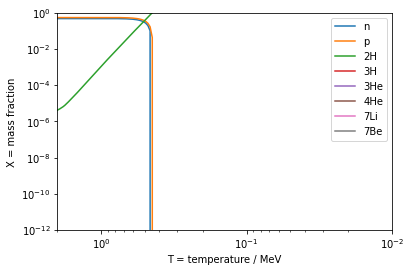

[ 5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205352e-01  5.32205352e-01  5.32205352e-01
  5.32205352e-01  5.32205

In [7]:
testing = Abundance()
T_vals, X = testing.BBN()
plt.axis([2, 1e-2, 1e-13, 2])
plt.loglog(T_vals, X.T)
plt.xlabel('T = temperature / MeV')
plt.ylabel('X = mass fraction')
plt.ylim(1e-12, 1e0)
plt.legend([testing.elem[i] for i in range(8)])
plt.show()

print(X[1])

